<font color='black'>
Content:

1. [DATA PREPARATION](#1) 
2. [CNN](#2)
3. [PREDICTION AND SUBMITION](#3)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

<a id="1"></a><br>
# DATA PREPARATION

In [3]:
# Load the data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [4]:
train.head()
print('Train size: ',train.shape)

Train size:  (42000, 785)


In [5]:
test.head()
print('Test size: ',test.shape)

Test size:  (28000, 784)


In [6]:
# put labels into y_train variable
Y = train["label"]
# Drop 'label' column
X = train.drop(labels = ["label"],axis = 1) 

In [7]:
import matplotlib.colors as mcolors

5, 0, 8, 7, 0, 8, 0, 0


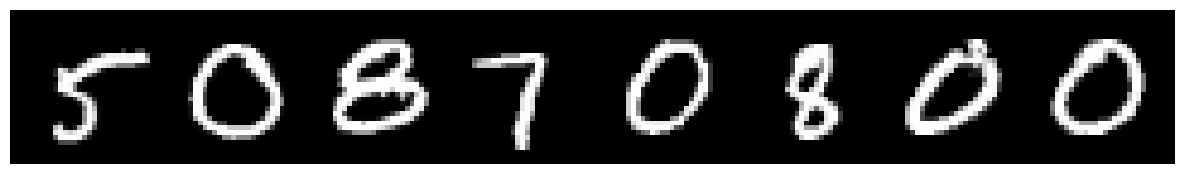

In [8]:
random_sel = np.random.randint(len(train), size=8)

grid = make_grid(torch.Tensor((train.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train.iloc[random_sel, 0].values), sep = ', ')


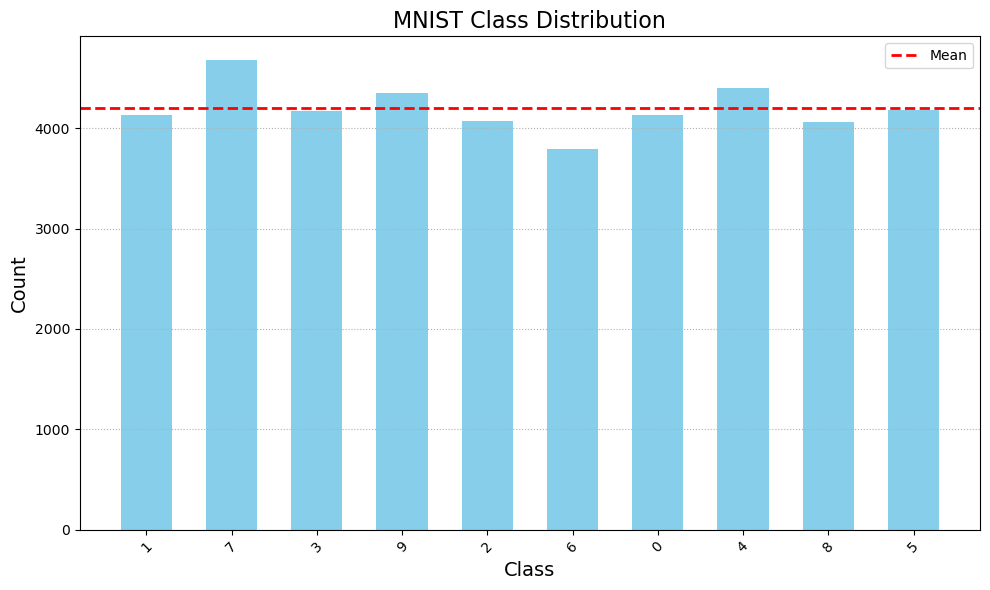

In [9]:
# Sınıf etiketleri ve sayıları
labels = Y.value_counts().index
counts = Y.value_counts()

# Özelleştirmeler
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu arttıralım
plt.bar(labels, counts, color='skyblue', width=0.6)  # Renk ve çubuk genişliği ayarları
plt.xticks(np.arange(len(labels)), labels, rotation=45)  # X eksenine sınıf etiketlerini döndürerek ekleyelim
plt.xlabel('Class', fontsize=14)  # X eksenine etiket ekleyelim
plt.ylabel('Count', fontsize=14)  # Y eksenine etiket ekleyelim
plt.title('MNIST Class Distribution', fontsize=16)  # Grafiğe başlık ekleyelim

# Yatay bir çizgi ekleyelim, tüm sınıfların eşit dağıtıldığını görsel olarak gösterelim
plt.axhline(counts.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')  

plt.legend()  # Açıklamaları gösterelim
plt.grid(axis='y', linestyle='dotted')  # Y eksenine ızgara ekleyelim

plt.tight_layout()  # Grafiği daha düzenli hale getirelim
plt.show()  # Grafiği gösterelim

In [10]:
# Normalize the data
X = X / 255.0
test = test / 255.0
print("X Shape: ",X.shape)
print("Test Shape: ",test.shape)

X Shape:  (42000, 784)
Test Shape:  (28000, 784)


In [11]:
from sklearn.model_selection import train_test_split
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.1, random_state=45)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (37800, 784)
x_val shape (4200, 784)
y_train shape (37800,)
y_val shape (4200,)


In [12]:
test = torch.from_numpy(test.values.reshape((-1,1,28,28)))
X_train = torch.from_numpy(X_train.values.reshape((-1,1,28,28)))
y_train= torch.from_numpy(y_train.values)
X_val = torch.from_numpy(X_val.values.reshape((-1,1,28,28)))
y_val = torch.from_numpy(y_val.values)

In [13]:
test.shape

torch.Size([28000, 1, 28, 28])

In [14]:
# define batch size
batch_size = 88

In [15]:
# define own dataset
class MNISTDataset(Dataset):
    """MNIST dataset"""
    
    def __init__(self, feature, target=None, transform=None):
        
        self.X = feature
        self.y = target
            
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # training
        if self.transform is not None:
            return self.transform(self.X[idx]), self.y[idx]
        # testing
        elif self.y is None:
            return [self.X[idx]]
        # validation
        return self.X[idx], self.y[idx]

In [16]:
# define transform operation
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor()])

# create dataset
train= MNISTDataset(X_train.float(), y_train, transform=data_transform)
val = MNISTDataset(X_val.float(), y_val)
test = MNISTDataset(test.float())

In [17]:
# load the data
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
validate_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

<a id="2"></a><br>
# CNN

In [18]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.cnn = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2),
                                     nn.Dropout(0.25),
                                     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2, stride=2),
                                     nn.Dropout(0.25))
        
        self.classifier = nn.Sequential(nn.Linear(576, 256),
                                       nn.Dropout(0.5),
                                       nn.Linear(256, 10))

        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1) # flatten layer
        x = self.classifier(x)
        
        return x

In [19]:
# defining the model
model = CNNModel()

# set optimizer, loss function, and learning rate reduction
# all these parameter comes from the first notebook in citation, the author explains the reason of choosing well
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

criterion = nn.CrossEntropyLoss()

lr_reduction = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0.00001)

In [20]:
# for visualization
count = 0
loss_list = []
iteration_list = []
average_training_accuracy = []
average_validation_accuracy = []
average_training_loss = []
average_validation_loss = []

In [21]:
from torch.autograd import Variable

def train(epoch):
    # print('Epoch ', epoch) # uncomment me to show verbose
    global count
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            count += 1

In [22]:
import torch.nn.functional as F

def evaluate(data_loader, validate=False):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    
    accuracy = 100. * correct / len(data_loader.dataset)
    
    if not validate:
        lr_reduction.step(loss)
        average_training_accuracy.append(accuracy)
        average_training_loss.append(loss)
    else:
        average_validation_accuracy.append(accuracy)
        average_validation_loss.append(loss)

In [23]:
n_epochs=70
for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)
    evaluate(validate_loader, True)
    train_loss = average_training_loss[-1]
    train_accuracy = average_training_accuracy[-1]
    val_loss = average_validation_loss[-1]
    val_accuracy = average_validation_accuracy[-1]

    print(f'Epoch [{epoch+1}/{n_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/70], Train Loss: 0.3762, Train Accuracy: 88.18%, Validation Loss: 0.1217, Validation Accuracy: 96.36%
Epoch [2/70], Train Loss: 0.2452, Train Accuracy: 92.17%, Validation Loss: 0.1062, Validation Accuracy: 96.98%
Epoch [3/70], Train Loss: 0.1449, Train Accuracy: 95.59%, Validation Loss: 0.0677, Validation Accuracy: 97.90%
Epoch [4/70], Train Loss: 0.1347, Train Accuracy: 95.88%, Validation Loss: 0.0590, Validation Accuracy: 98.36%
Epoch [5/70], Train Loss: 0.1067, Train Accuracy: 96.74%, Validation Loss: 0.0453, Validation Accuracy: 98.69%
Epoch [6/70], Train Loss: 0.1103, Train Accuracy: 96.76%, Validation Loss: 0.0643, Validation Accuracy: 98.29%
Epoch [7/70], Train Loss: 0.0889, Train Accuracy: 97.32%, Validation Loss: 0.0484, Validation Accuracy: 98.67%
Epoch [8/70], Train Loss: 0.0892, Train Accuracy: 97.30%, Validation Loss: 0.0396, Validation Accuracy: 98.69%
Epoch [9/70], Train Loss: 0.0985, Train Accuracy: 97.12%, Validation Loss: 0.0486, Validation Accuracy: 98.55%
E

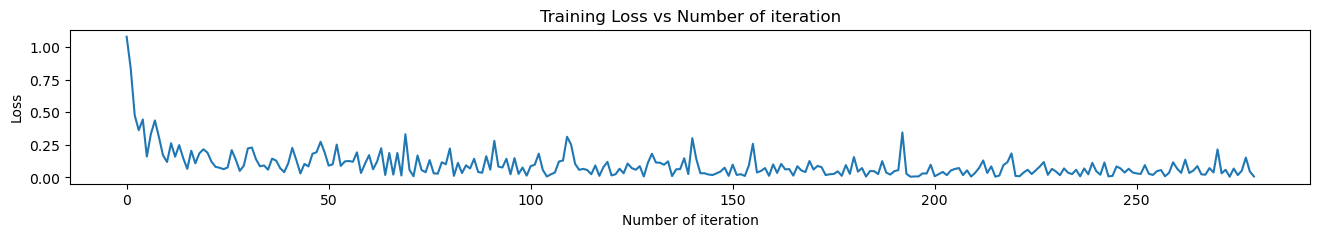

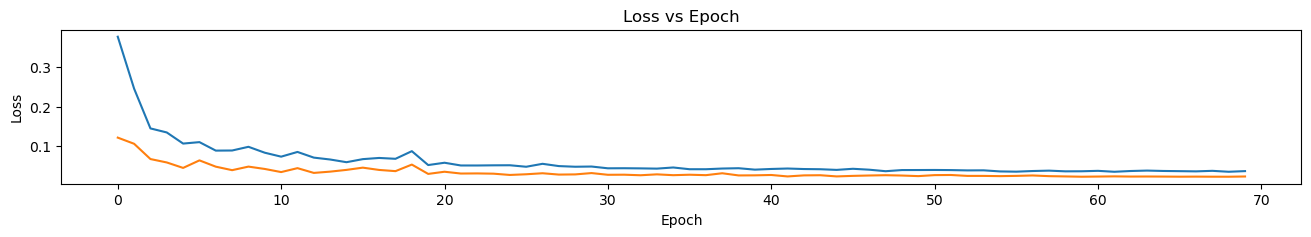

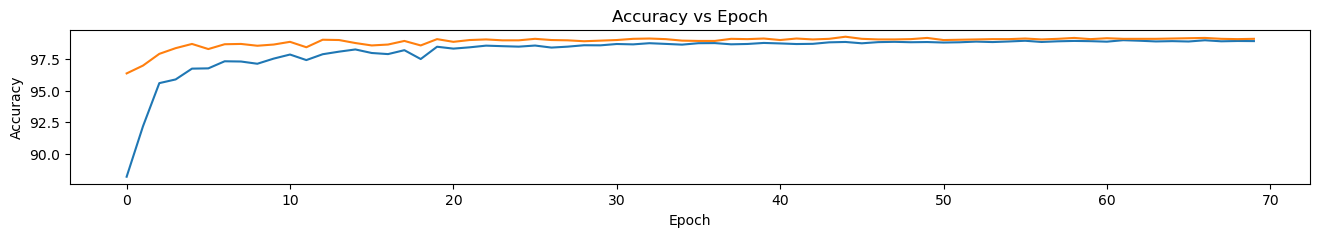

In [24]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Training Loss vs Number of iteration")
plt.show()

epoch_list = [i for i in range(n_epochs)]

plt.plot(epoch_list, average_training_loss)
plt.plot(epoch_list, average_validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

plt.plot(epoch_list, average_training_accuracy)
plt.plot(epoch_list, average_validation_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.show()

<a id="3"></a><br>
# PREDICTION AND SUBMITION

In [25]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        
        data = Variable(data[0])
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

test_pred = prediciton(test_loader)

In [26]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

# check prediction makes sense
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [28]:
out_df.to_csv('cnn5.csv', index=False)